# Default Pytorch pruning

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [19]:
import fastprogress
import fastai
from fastai import *
from fastai.text import *
from fastai.vision import *

### Disable the progress bar

In [20]:
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = fastprogress.force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastai.basic_data.master_bar, fastai.basic_data.progress_bar = master_bar, progress_bar
dataclass.master_bar, dataclass.progress_bar = master_bar, progress_bar
fastai.text.master_bar, fastai.text.progress_bar = master_bar, progress_bar
fastai.text.data.master_bar, fastai.text.data.progress_bar = master_bar, progress_bar
fastai.core.master_bar, fastai.core.progress_bar = master_bar, progress_bar

In [21]:
bs = 64
epochs = 3

In [22]:
class Net(nn.Module):
    def __init__(self, mnist=True):
        super().__init__()
          
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [23]:
path = untar_data(URLs.MNIST)

In [24]:
data = (ImageList.from_folder(path)
                .split_by_folder(train='training', valid='testing')
                .label_from_folder()
                .databunch()
                .normalize())

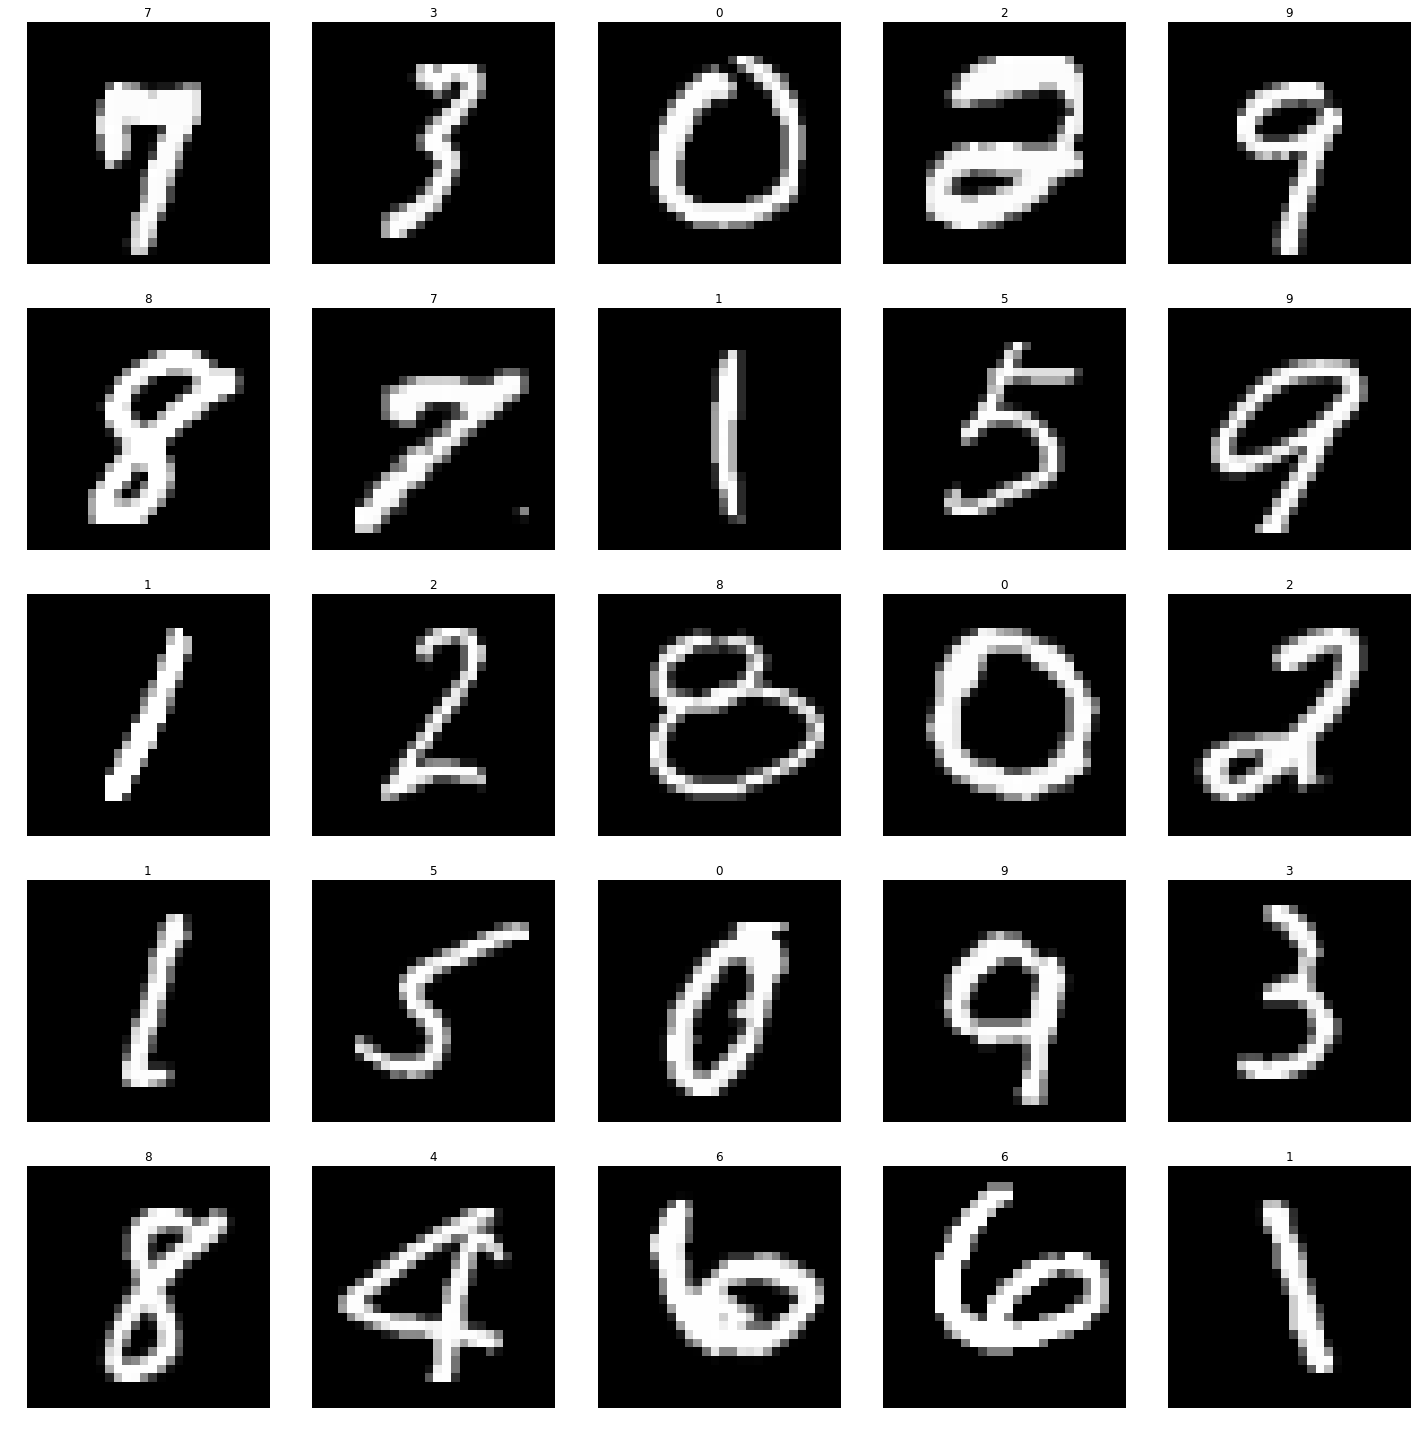

In [25]:
data.show_batch()

## Compute Target Sparsity

In [56]:
class Sparsifier():
    def __init__(self, meta):
        self.meta = meta
    
    def _compute_sparsity(self, meta):
        return meta['final_sparsity'] + (meta['initial_sparsity'] - meta['final_sparsity'])*(1 - (meta['current_step'] - meta['starting_step'])/((meta['ending_step'] - meta['starting_step'])))**3

    def prune(self, model, meta):
  
        binary_masks = {}
  
        sparsity = self._compute_sparsity(meta)
    
        for k, m in enumerate(model.children()):

            if isinstance(m, nn.Linear):

                weight = m.weight.data.view(-1).clone().abs()
                y, i = torch.sort(weight)

                spars_index = int(weight.shape[0]*sparsity/100)
                threshold = y[spars_index]
                mask = weight.gt(threshold).float().cuda()
                
                mask = mask.view(m.weight.data.shape)
      
                binary_masks[k] = mask
                m.weight.data.mul_(mask)
  
        return model, binary_masks    
        

    def applyBinaryMasks(self, model, masks):
  
        for k, m in enumerate(model.children()):

            #if not isinstance(m, Net):
                mask = masks[k]
                m.weight.data.mul_(mask)
    
        return model

@dataclass
class SparsifyCallback(Callback):
    learn:Learner
        
    def __init__(self, meta):
        self.meta = meta
        self.sparsifier = Sparsifier(self.meta)
        #self.sparsities = []
        
        self.binary_masks = None
        
    def on_epoch_end(self, **kwargs):
        print(f'Current model sparsity: {self.sparsifier._compute_sparsity(self.meta):.2f} %')
        
    def on_batch_end(self, **kwargs):
        #self.sparsities.append(self.sparsifier._compute_sparsity(self.meta))
        pass
        
    def on_batch_begin(self, **kwargs):
        
        if learn.model.training: # To avoid pruning during the validation phase
            self.meta['current_step'] += 1

        if self.binary_masks:
            learn.model = self.sparsifier.applyBinaryMasks(learn.model, self.binary_masks)
          
        
        if (self.meta['current_step'] - self.meta['starting_step']) % self.meta['span'] == 0 and self.meta['current_step'] > self.meta['starting_step']:
            learn.model, self.binary_masks = self.sparsifier.prune(learn.model, self.meta)
    


In [57]:
prune_meta = {
        "starting_step" : 0,
        "current_step": 0,
        "ending_step": epochs * len(data.train_dl),
        "final_sparsity": 90,
        "initial_sparsity": 0,
        "span": 100
    }

In [58]:
learn = Learner(data, Net().cuda(), callbacks=SparsifyCallback(meta=prune_meta), metrics=accuracy)

In [59]:
learn.fit(epochs, 1e-3)

epoch     train_loss  valid_loss  accuracy  time    


RuntimeError: The size of tensor a (20) must match the size of tensor b (5) at non-singleton dimension 3

In [47]:
def model_stats(model):
        for k, m in enumerate(model.modules()):

            if not isinstance(m, Net):

                weight = m.weight.data.view(-1).clone().abs()
                non_zero_weights = weight.gt(0).float().cuda().sum()                
                total_weights = weight.shape[0]
                zero_weights = 100 - int(non_zero_weights*100/total_weights)
                print(m)
                print("Percentage of zero weights: ", zero_weights)

In [48]:
model_stats(learn.model)

Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
Percentage of zero weights:  90
BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Percentage of zero weights:  90
Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Percentage of zero weights:  90
BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Percentage of zero weights:  90
Linear(in_features=800, out_features=500, bias=True)
Percentage of zero weights:  90
Linear(in_features=500, out_features=10, bias=True)
Percentage of zero weights:  90
